# Variational Autoencoder

VAE는 데이터가 생성되는 과정, 즉 데이터의 확률분포를 학습하기 위한 두 개의 뉴럴네트워크로 구성되어 있습니다. VAE는 잠재변수(latent variable) z를 가정하고 있는데요. 우선 encoder라 불리는 뉴럴네트워크는 관측된 데이터 x를 받아서 잠재변수 z를 만들어 냅니다. decoder라 불리는 뉴럴네트워크는 encoder가 만든 z를 활용해 x를 복원해내는 역할을 합니다. VAE 아키텍처는 다음 그림과 같습니다.

### 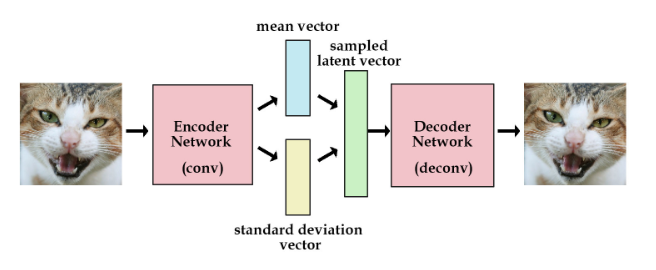

### 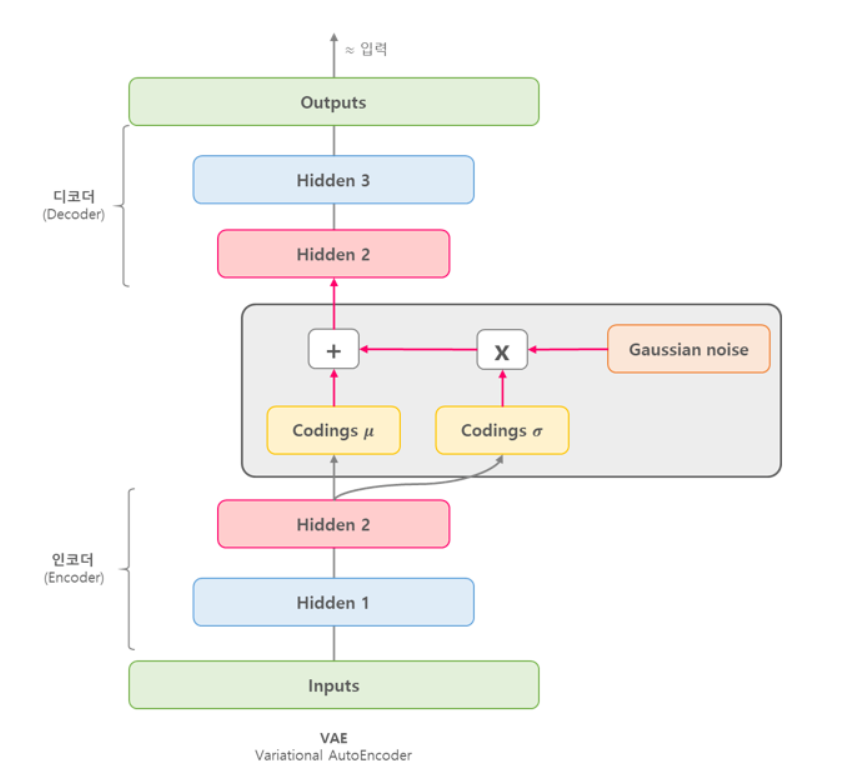

- 1. AE의 한 종류!
- 2. Variational Inference ( 변분추론 ) ( 그림 (1) 참고 )
- 2. 차이점 : 일반AE처럼 특징을 잘 잡아내는 hidden layer초점보다, 새로운 걸 generate하는 것을 중시!
- 3. 주어진 입력에 대해 바로 코딩하는 것 X ( mean & sd 코딩부터 만듬 )
- 4. "위에서 만든 mean & sd의 분포에서 랜덤하게 샘플링 되고, decoder가 이렇게 랜덤하게 샘플링 된 것을 원본 입력(x)로 재구성!"
- 5. VAE의 손실함수 ( 그림 (2) 참고 )
- 6. 장점 :  GAN에 비해 학습이 안정적 ( reconstruction error 생각하면 왜인지는 알겠지? generating + feature learning 둘 다 가능! 
- 7. 단점 : 출력이 선명하지 않고, 평균값 형태로 표시되는 형태 ( GAN보다 창의성이 적다고 해야하나... )
- 8. Advanced - (1) CVAE ( Conditional VAE ) : 기존 VAE 구조를 지도 학습이 가능하도록! encoder와 decoder에 정답 label y 추가! ( 그림 (3) 참고 )
- 9. Advanced - (2) Adversarial Autoencoder : VAE + GAN ( 그림 (4) 참고 )

### (그림 1) Variational Inference
- 사후 확률분포를 "다루기 쉬운 확률분포"로 근사하는 것
- KL Divergence : 두 확률분포의 차이를 계산하는 데 사용하는 함수. 이 값을 줄이는 방향으로 학습!
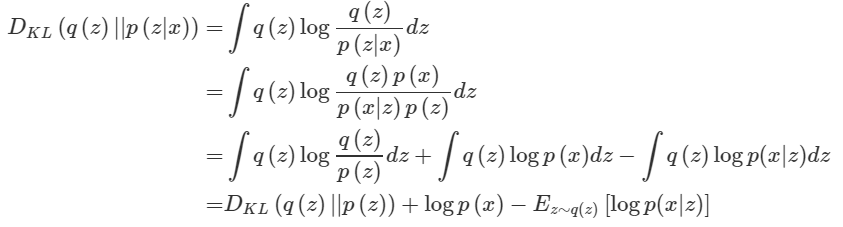

### 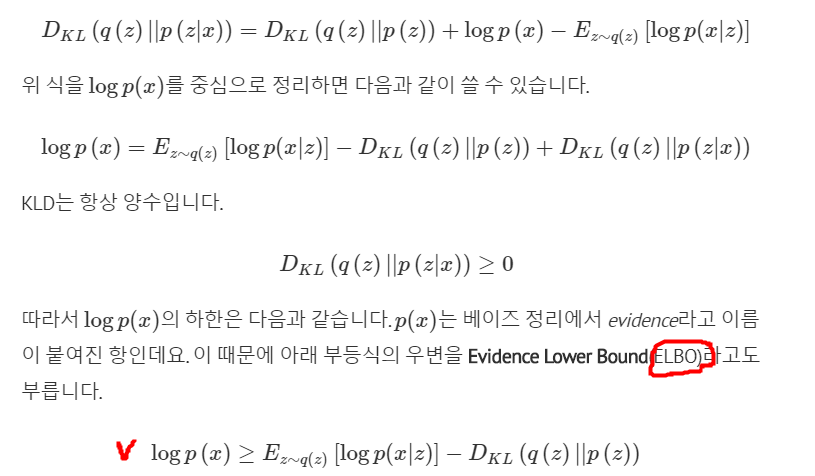

### (그림 2)
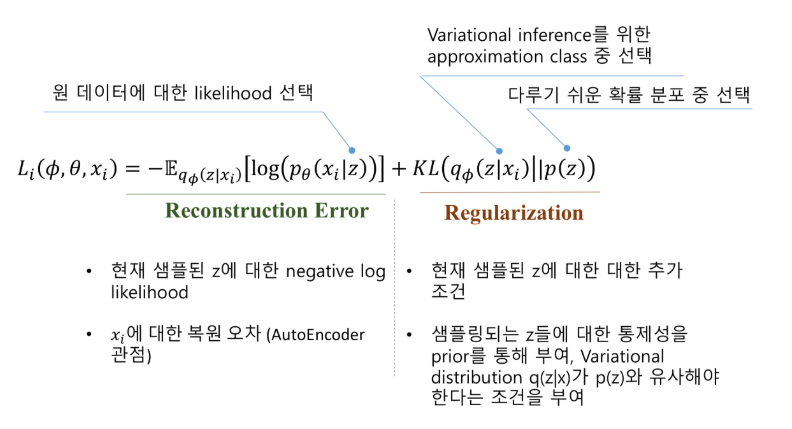

### (그림 3)
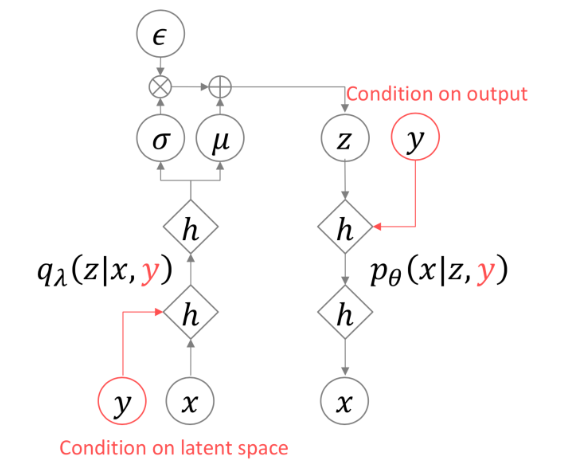

### (그림 4) Adversarial Autoencoder
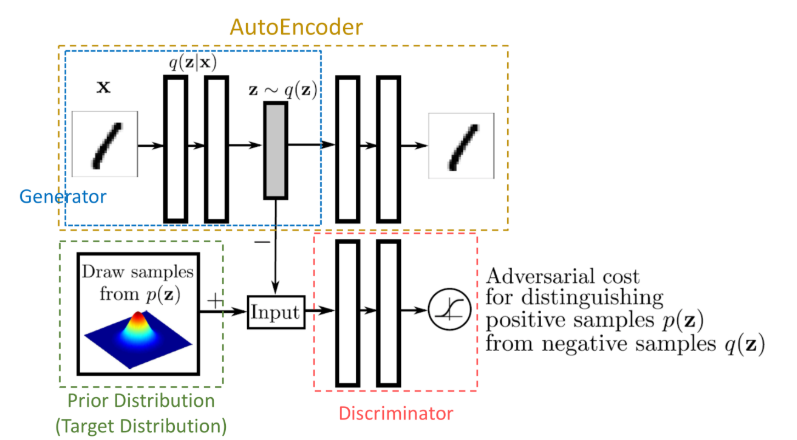

In [1]:
import tensorflow as tf
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

### importing dataset

In [43]:
(train_img,_), (test_img,_) = tf.keras.datasets.mnist.load_data()

In [44]:
#train_img = train_img[...,tf.newaxis].astype('float32')
train_img = train_img.reshape(train_img.shape[0], 28,28,1).astype('float32')
#test_img = test_img[...,tf.newaxis].astype('float32')
test_img = test_img.reshape(test_img.shape[0], 28,28,1).astype('float32')
train_img = train_img / 255.
test_img = test_img / 255.

### binary

In [45]:
train_img[train_img>=0.5] = 1.
train_img[train_img<0.5] = 0.
test_img[test_img>=0.5] = 1.
test_img[test_img<0.5] = 0.

In [46]:
test_img.shape[0]

10000

In [47]:
batch_size = 100
train_buf = train_img.shape[0]
test_buf = test_img.shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices(train_img).shuffle(train_buf).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_img).shuffle(test_buf).batch(batch_size)

## Network Architecture
- 2 Convs, followed by FC
- avoid using BN when training VAE! ( instability on sampling )

In [48]:
from tensorflow.keras import layers

In [49]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE,self).__init__()
        self.latent_dim = latent_dim
        
        self.inference_net = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=(28,28,1)),
                layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu'),
                layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu'),
                layers.Flatten(),
                layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.generative_net = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=(latent_dim,)),
                layers.Dense(units=7*7*32,activation=tf.nn.relu),
                layers.Reshape(target_shape=(7,7,32)),
                layers.Conv2DTranspose(
                    filters=64,kernel_size=3,strides=(2,2),padding='SAME',activation='relu'),
                layers.Conv2DTranspose(
                    filters=32,kernel_size=3,strides=(2,2),padding='SAME',activation='relu'),
                layers.Conv2DTranspose(
                    filters=1,kernel_size=3,strides=(1,1),padding='SAME'),
            ]
        )

        # sample : making many samples!  
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs

        return logits

### Loss Function & Optimizer

In [50]:
opt = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2.0 * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model,x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean,logvar) # z : latent feature
    x_logit = model.decode(z)                       # x_logit : 새로 생성한 유사 x
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    
    # ELBO
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2,3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z,mean,logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model,x)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

## Generate Images
- start by sampling a set of latent vactors from p(z) (Gaussian prior distribution)
- plot the prob of Bernoulli distribution

In [51]:
epochs = 100
latent_dim = 50
num_ex = 16

rand_generation = tf.random.normal(shape=[num_ex, latent_dim])

model = VAE(latent_dim)

In [52]:
def generate_and_save_images(model, epoch, test_input):
    pred = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))
    
    for i in range(pred.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(pred[i,:,:,0], cmap='gray')
        plt.axis('off')
        
    #plt.savefig('image_at_epoch_{:0.4d}.png'.format(epoch))
    plt.show()

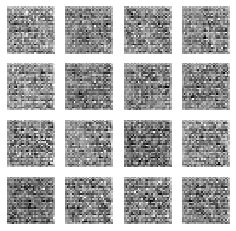

In [53]:
generate_and_save_images(model,0,rand_generation)

### https://www.tensorflow.org/tutorials/generative/cvae